In [54]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Devices Available: {device}')

Devices Available: cpu


In [56]:
image_path = []
label = []
for folder in os.listdir('Data'):
  for image in os.listdir(f'Data/{folder}'):
    image_path.append(f'Data/{folder}/{image}')
    label.append(folder)

In [57]:
images_df = pd.DataFrame(zip(image_path, label), columns=['Image Path', 'Label'])
images_df

,Image Path,Label
0,Data/A/Image_1.jpg,A
1,Data/A/Image_10.jpg,A
2,Data/A/Image_100.jpg,A
3,Data/A/Image_101.jpg,A
4,Data/A/Image_102.jpg,A
...,...,...
953,Data/C/Image_95.jpg,C
954,Data/C/Image_96.jpg,C
955,Data/C/Image_97.jpg,C
956,Data/C/Image_98.jpg,C


In [58]:
train_df, test_df = train_test_split(images_df, train_size=0.7, random_state=42)

In [59]:
train_df

,Image Path,Label
228,Data/A/Image_304.jpg,A
319,Data/A/Image_57.jpg,A
715,Data/C/Image_167.jpg,C
212,Data/A/Image_290.jpg,A
79,Data/A/Image_170.jpg,A
...,...,...
106,Data/A/Image_195.jpg,A
270,Data/A/Image_342.jpg,A
860,Data/C/Image_298.jpg,C
435,Data/B/Image_161.jpg,B


In [60]:
test_df

,Image Path,Label
836,Data/C/Image_276.jpg,C
477,Data/B/Image_2.jpg,B
350,Data/A/Image_85.jpg,A
891,Data/C/Image_39.jpg,C
855,Data/C/Image_293.jpg,C
...,...,...
501,Data/B/Image_220.jpg,B
796,Data/C/Image_24.jpg,C
634,Data/B/Image_94.jpg,B
405,Data/B/Image_134.jpg,B


In [61]:
encoder = LabelEncoder()
encoder.fit(images_df['Label'])

LabelEncoder()

In [62]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [63]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label = torch.tensor(encoder.transform(dataframe['Label'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        label = self.label[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [64]:
train_dataset = CustomImageDataset(dataframe=train_df, transform=transform)
test_dataset = CustomImageDataset(dataframe=test_df, transform=transform)

In [65]:
print('Train Dataset:', train_dataset.__len__())
print('Test Dataset:', test_dataset.__len__())

Train Dataset: 670
Test Dataset: 288


In [66]:
train_dataset.__getitem__(2)

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor(2))

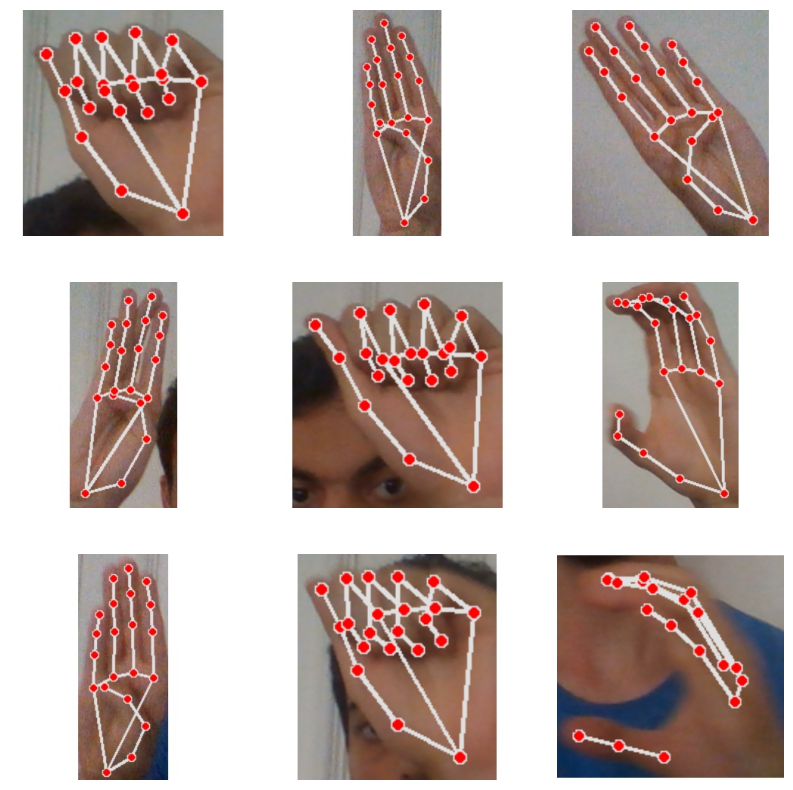

In [67]:
rows = 3
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))


for row in range(rows):
    for col in range(cols):
        image = Image.open(images_df.sample(1)['Image Path'].iloc[0]).convert('RGB')
        axes[row][col].imshow(image)
        axes[row][col].axis('off')

plt.show()

In [68]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 16 

In [69]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [70]:
class SignLanguageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(images_df['Label'].unique()))

    def forward(self, x):
        for conv in [self.conv1, self.conv2, self.conv3]:
            x = self.relu(self.pooling(conv(x)))

        x = self.flatten(x)
        x = self.linear(x)

        return self.output(x)

In [71]:
model = SignLanguageClassifier().to(device)

In [72]:
from torchsummary import summary

summary(model, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,287,491
Trainable params: 4,287,491
Non-trainable params: 0
---------------------------

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
for epoch in range(EPOCHS):
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += labels.size(0)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss / len(train_loader):.4f} | Accuracy: {100 * total_correct / total_samples:.2f}%")

model.eval()
correct = 0
total = 0
loss_total = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_total += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

print(f"Test Loss: {loss_total / len(test_loader):.4f} | Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/16 | Loss: 0.7279 | Accuracy: 68.51%
Epoch 2/16 | Loss: 0.3980 | Accuracy: 87.76%
Epoch 3/16 | Loss: 0.1910 | Accuracy: 95.67%
Epoch 4/16 | Loss: 0.0991 | Accuracy: 97.16%
Epoch 5/16 | Loss: 0.0486 | Accuracy: 98.21%
Epoch 6/16 | Loss: 0.0319 | Accuracy: 98.96%
Epoch 7/16 | Loss: 0.0181 | Accuracy: 99.70%
Epoch 8/16 | Loss: 0.0079 | Accuracy: 100.00%
Epoch 9/16 | Loss: 0.0047 | Accuracy: 100.00%
Epoch 10/16 | Loss: 0.0034 | Accuracy: 100.00%
Epoch 11/16 | Loss: 0.0021 | Accuracy: 100.00%
Epoch 12/16 | Loss: 0.0018 | Accuracy: 100.00%
Epoch 13/16 | Loss: 0.0014 | Accuracy: 100.00%
Epoch 14/16 | Loss: 0.0010 | Accuracy: 100.00%
Epoch 15/16 | Loss: 0.0008 | Accuracy: 100.00%
Epoch 16/16 | Loss: 0.0006 | Accuracy: 100.00%
Test Loss: 0.0109 | Test Accuracy: 99.65%


In [75]:
torch.save(model.state_dict(), 'sign_language_model.pth')

In [76]:
import joblib

joblib.dump(encoder, 'label_encoder.pkl')

['label_encoder.pkl']